In [1]:
%load_ext lab_black

# Two parameter inference

This example illustrates parameter inference for the discount factor $\delta$ and the wage constant in sector a for the setting of Keane-Wolpin [(1994)](https://www.jstor.org/stable/2109768?seq=1).

In this example the following moduels from `respyabc` are used:

- Distance function for the descriptives:`distances.compute_mean_squared_distance`
- Get point estimate from inference: `evaluation.compute_point_estimate`
- Plot credibility intervals from inference:`evaluation.plot_credible_intervals`
- Plot posterior distribution from inference:`evaluation.plot_kernel_density_posterior`
- Simulation function of the model:`models.compute_model` 
- Inference function:`respyabc.respyabc`

We can import the necessary classes and packages by

In [2]:
import respy as rp
import numpy as np

import time

from respyabc.distances import compute_mean_squared_distance
from respyabc.evaluation import compute_point_estimate
from respyabc.evaluation import plot_credible_intervals
from respyabc.evaluation import plot_kernel_density_posterior
from respyabc.models import compute_model
from respyabc.respyabc import respyabc
from respyabc.tools import convert_time

## Load the default settings

First, we load the settings from the first model in Keane-Wolpin [(1994)](https://www.jstor.org/stable/2109768?seq=1) using `respy`. 

In [3]:
params, options, data_stored = rp.get_example_model("kw_94_one")

The model consits of 4 choices *sector a, sector b, schooling* and *staying at home*. This yields 30 parameters within the model. In this tutorial, we only vary over the discount factor, which is in the standard parameterization $\delta = 0.95$.

In [4]:
delta_default = params.loc[("delta", "delta")]["value"]
constant_a_default = params.loc[("wage_a", "constant")]["value"]

f"The default value of delta is {delta_default}."

'The default value of delta is 0.95.'

In [5]:
f"The default value of the wage constant in sector a is {constant_a_default}."

'The default value of the wage constant in sector a is 9.21.'

## Simulate the true population

For clarification, we reassign the default values to show how values with other options can be simulated. For a more detaield description see the tutorial on one parameter. We can address the wage constant using a melted index from its multiindex in `params`.

In [6]:
model_to_simulate = rp.get_simulate_func(params, options)
parameter_true = {"delta_delta": 0.95, "wage_a_constant": 9.21}

As for one parameter, the model is subsequently passed to `respyabc`'s `compute_model` function.

In [7]:
np.random.seed(123)
pseudo_observed_data = compute_model(
    parameter_true,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

## Set the pyABC parameters

We set the size of the `pyABC` samples to 500 and the maximum number of drawn populations to 10. The excact magnitudes in applications depend on the respective application.

In [12]:
population_size = 500
max_nr_populations = 10

For the two parameter inference, we need to define one prior distribution for each parameter.

In [13]:
minimum_epsilon = 0.05
delta_prior_low = 0.9
delta_prior_length = 0.09
wage_a_constant_prior_low = 9
wage_a_constant_prior_length = 0.6
parameters_prior = {
    "delta_delta": [[delta_prior_low, delta_prior_length], "uniform"],
    "wage_a_constant": [
        [wage_a_constant_prior_low, wage_a_constant_prior_length],
        "uniform",
    ],
}

## respyabc inference

As distance, we used the mean squared distances of the choice frequencies of any period. After specifying all relevant parameters, inference is conducted by using the `respyabc` function. We keep track of the simulation time to give the user a first glimpse about the timing. 

In [14]:
np.random.seed(1234)
start_time = time.perf_counter()
history = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior,
    data=pseudo_observed_data,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_time = time.perf_counter()

/home/manuel/anaconda3/lib/python3.7/site-packages/respy/pre_processing/model_processing.py:104: UserWarning: All seeds should be different.
  warnings.warn("All seeds should be different.", category=UserWarning)
/home/manuel/anaconda3/lib/python3.7/site-packages/respy/pre_processing/model_processing.py:104: UserWarning: All seeds should be different.
  warnings.warn("All seeds should be different.", category=UserWarning)
/home/manuel/anaconda3/lib/python3.7/site-packages/respy/pre_processing/model_processing.py:104: UserWarning: All seeds should be different.
  warnings.warn("All seeds should be different.", category=UserWarning)
/home/manuel/anaconda3/lib/python3.7/site-packages/respy/pre_processing/model_processing.py:104: UserWarning: All seeds should be different.
  warnings.warn("All seeds should be different.", category=UserWarning)
/home/manuel/anaconda3/lib/python3.7/site-packages/respy/pre_processing/model_processing.py:104: UserWarning: All seeds should be different.
  warni

In [15]:
delta_time, delta_unit = convert_time(end_time - start_time)
f"The respyabc run for delta using choice frequencies took {delta_time:0.2f} {delta_unit}"

'The respyabc run for delta using choice frequencies took 17.92 minutes'

## respyabc evaluation

First, we compute the point estimate and its variance for both parameters. The estimate is computed by `point_estimate` as a weighted average over the latest simulated population. 

In [16]:
estimate = compute_point_estimate(history)
estimate

name,delta_delta,wage_a_constant
estimate,9.348694e-01,9.126213
est_variance,3.141319e-07,0.000009


To obtain a broader overview on how the estimates evolve over the runs, we have implemented $95\%$ credibility intervals by the function `plot_credible_intervals`. The argument `interval_type=simulated` indicates that the credibility intervals are computed as $2.5\%$ and $97.5\%$ percentiles of the simulated population. We do so for both parameters.

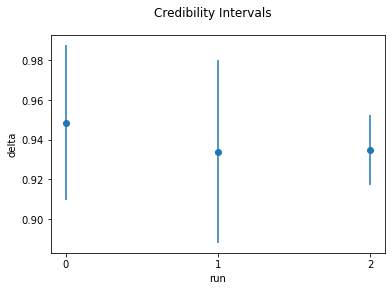

In [17]:
plot_credible_intervals(
    history=history,
    parameter="delta_delta",
    interval_type="simulated",
    alpha=0.05,
    main_title="Credibility Intervals",
    y_label="delta",
)

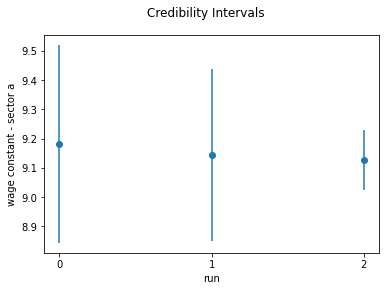

In [18]:
plot_credible_intervals(
    history=history,
    parameter="wage_a_constant",
    interval_type="simulated",
    alpha=0.05,
    main_title="Credibility Intervals",
    y_label="wage constant - sector a",
)

Computing the posterior distributions can be done analogously by `plot_kernel_density_posterior` and specifying the respective argument for `parameter`.

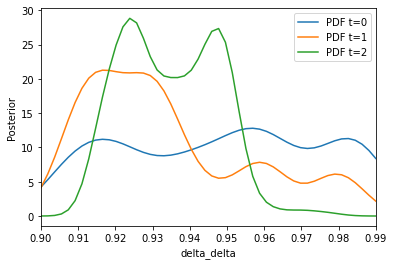

In [19]:
xmax_delta = delta_prior_low + delta_prior_length
plot_kernel_density_posterior(
    history=history, parameter="delta_delta", xmin=delta_prior_low, xmax=xmax_delta
)

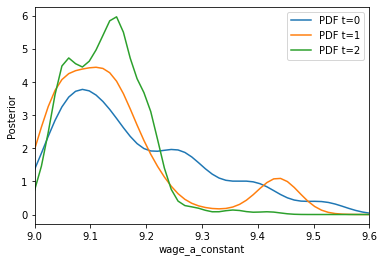

In [20]:
xmax_constant = wage_a_constant_prior_low + wage_a_constant_prior_length
plot_kernel_density_posterior(
    history=history,
    parameter="wage_a_constant",
    xmin=wage_a_constant_prior_low,
    xmax=xmax_constant,
)